Activity 1
Analog IC Characterization: The Wideband RC Voltage-Divider

I. INTRODUCTION

The frequency-independent signal attenuator is a fundamental building block in high-bandwidth analog measurement systems, where accurate signal scaling must be maintained over a wide range of frequencies. Simple resistive voltage dividers, while effective at low frequencies, often exhibit frequency-dependent behavior when parasitic capacitances and source or load impedances are introduced. These effects become especially pronounced in wideband applications, leading to signal distortion, amplitude errors, and phase shift.

To address these limitations, RC compensation techniques are employed. By intentionally adding capacitive elements in parallel with resistive components, the frequency response of the divider can be shaped to achieve flat attenuation across a broad spectrum. This principle is widely used in practical instrumentation such as oscilloscope probes, data acquisition front-ends, and analog integrated circuits, where maintaining signal integrity is critical.

This laboratory activity examines the wideband RC voltage divider as a representative analog IC building block. Students will explore the theoretical basis of RC compensation, including pole-zero cancellation and time-constant matching, and observe how these concepts translate into real circuit behavior. Emphasis is placed on understanding how component values influence bandwidth, transient response, and overall signal fidelity.

In addition to theory, the laboratory integrates circuit simulation using NGSPICE within a Visual Studio Code (VS Code) workflow. This environment mirrors modern engineering practice by combining schematic-level analysis with script-based simulation and waveform inspection. Through simulation, students will characterize both uncompensated and compensated dividers in the time and frequency domains, reinforcing the connection between mathematical models and observable circuit performance.

II. MATERIALS AND EQUIPMENT

Computing Workstation (PC or Laptop)

Integrated Development Environment (IDE): Visual Studio Code

NGSPICE Simulator: (Version 42+)

Python 3.x (pandas, matplotlib, numpy, schemdraw)

III. PROCEDURES

PHASE 1: INSTALLATION & SYSTEM CONFIGURATION

Step 1: Install NGSPICE (The Simulator)

    Download ngspice-42_64.zip from the NGSPICE SourceForge page.

    Extract the file and copy the Spice64 folder.

    Paste it directly into the C: drive:

            C:\Spice64
    
    Verify that ngspice.exe exists in:

            C:\Spice64\bin

Step 2: Add NGSPICE to Windows PATH

    Copy Path:

        C:\Spice64\bin

    Open Edit the system environment variables.

    Under System variables → Path → Edit → New, paste the path.

    Click OK to save.

Step 3: Verify in VS Code

    Restart VS Code.

    Open the terminal (Ctrl + `).

    Run:

        ngspice -v
    
    The NGSPICE version output confirms successful installation.

PHASE 2: PYTHON ENVIRONMENT SETUP
Install Required Python Libraries

Purpose:
These libraries will be used for circuit visualization (schemdraw), data handling (pandas), numerical analysis (numpy), and plotting simulation results (matplotlib).

In [46]:
pip install schemdraw pandas matplotlib numpy

Note: you may need to restart the kernel to use updated packages.


Verify NGSPICE Availability

Purpose:
Confirms that NGSPICE is correctly installed and accessible from the Jupyter Notebook environment before running simulations.

In [52]:
import schemdraw
import schemdraw.elements as elm
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import subprocess
import os

# Robust verification: This checks if NGSPICE is accessible
try:
    result = subprocess.run(["ngspice", "-v"], capture_output=True, text=True)
    if result.stdout:
        # Print the first available line of the version info
        print(f"NGSPICE Found: {result.stdout.splitlines()[0]}")
    else:
        print("NGSPICE executed but returned no version text.")
except FileNotFoundError:
    print("ERROR: NGSPICE not found. Please check your Windows PATH and restart VS Code.")

NGSPICE executed but returned no version text.


PHASE 3: CIRCUIT SCHEMATIC VISUALIZATION
Draw RC Divider Circuit

Purpose:
This cell visualizes the wideband RC voltage divider, showing:
    R1 with compensation capacitor C1
    Load resistor R2 and load capacitor C2
    Input Vin and output Vout nodes

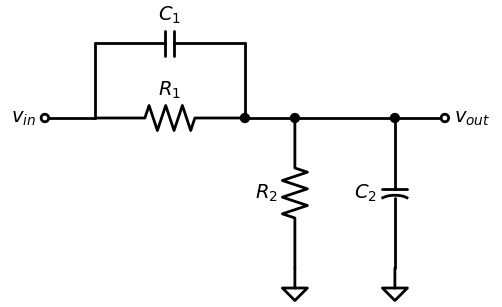

In [79]:
with schemdraw.Drawing() as d:
    d += (vin := elm.Dot(open=True).label('$v_{in}$', loc='left'))
    d += elm.Line().right().length(1)
    d.push()
    d += elm.Resistor().label('$R_1$')
    d.pop()
    d += elm.Line().up().length(1.5)
    d += elm.Capacitor().right().label('$C_1$')
    d += elm.Line().down().length(1.5)
    d += elm.Dot()
    d += elm.Line().right().length(1)
    d.push()
    d += elm.Resistor().down().label('$R_2$')
    d += elm.GroundSignal()
    d.pop()
    d += elm.Dot()
    d += elm.Line().right().length(2)
    d.push()
    d += elm.Capacitor2().down().label('$C_2$')
    d += elm.GroundSignal()
    d.pop()
    d += elm.Dot()
    d += elm.Line().right().length(1)
    d += elm.Dot(open=True).label('$v_{out}$', loc='right')

PHASE 4: NGSPICE NETLIST GENERATION & SIMULATION
Generate Netlist, Run Simulation, and Verify Output

Purpose:
    Generates a complete NGSPICE netlist using Python-defined component values.
    Runs AC and transient analyses in batch mode.
    Verifies that data files (output_ac.dat, output_tran.dat) are created for further plotting and analysis.

In [83]:
spice_netlist = """* Wideband RC Voltage Divider
.options savecurrents

* Main Circuit
R1 in out 3.3Meg
R2 out 0 150k
C1 in out 12.2727p
C2 out 0 270p

* Variations
R1a in outa 3.3Meg
R2a outa 0 150k
C1a in outa 13.49997p
C2a outa 0 270p

R1b in outb 3.3Meg
R2b outb 0 150k
C1b in outb 11.04543p
C2b outb 0 270p

V1 in 0 pulse(-0.1 0.1 0 0.1u 0.1u 5u 10u) dc 1 ac 1

.control
  ac dec 10 1 1G
  wrdata output_ac.dat v(out) v(outa) v(outb)
  
  tran 0.01u 30u
  wrdata output_tran.dat v(out) v(outa) v(outb)
  quit
.endc
.end
"""

with open("netlist.spice", "w") as f:
    f.write(spice_netlist)
print("netlist.spice created.")

netlist.spice created.


RUN SIMULATION WITH FILE CLEANUP
Ensure Fresh Simulation and Verify Output

Purpose:

    Ensures old simulation files are removed before running a new simulation.
    Runs NGSPICE in batch mode and verifies that AC and transient data files are generated.
    Provides immediate feedback if something goes wrong.

In [84]:
import subprocess
import os

# Remove old files to be sure we are seeing new results
for f in ["output_ac.dat", "output_tran.dat"]:
    if os.path.exists(f):
        os.remove(f)

try:
    # Running in batch mode
    subprocess.run(["ngspice", "-b", "netlist.spice"], check=True)
    
    if os.path.exists("output_tran.dat"):
        print("Success! Simulation finished and data files are ready.")
    else:
        print("Simulation finished but no data files were found.")
except subprocess.CalledProcessError as e:
    print(f"Simulation failed with error code {e.returncode}")

Success! Simulation finished and data files are ready.


PHASE 5: PLOT TRANSIENT RESPONSE
    Read and Plot Transient Data

Data detected: 6 columns


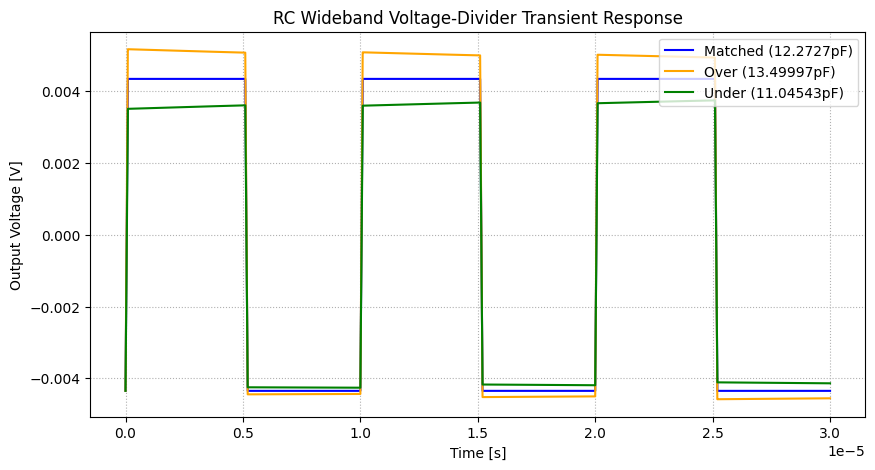

In [90]:
# Read the file without specifying columns first
df_tran = pd.read_csv("output_tran.dat", sep='\\s+', header=None)

# Let's check the shape to be safe
print(f"Data detected: {df_tran.shape[1]} columns")

# NGSPICE often exports: Time, Vout, Time, VoutA, Time, VoutB
# We only need the first Time and the Voltages
if df_tran.shape[1] == 6:
    df_tran.columns = ["time", "vout", "time2", "vouta", "time3", "voutb"]
elif df_tran.shape[1] == 4:
    df_tran.columns = ["time", "vout", "vouta", "voutb"]

# Plotting
plt.figure(figsize=(10, 5))
plt.plot(df_tran['time'], df_tran['vout'], label="Matched (12.2727pF)", color='blue')
plt.plot(df_tran['time'], df_tran['vouta'], label="Over (13.49997pF)", color='orange')
plt.plot(df_tran['time'], df_tran['voutb'], label="Under (11.04543pF)", color='green')

plt.title("RC Wideband Voltage-Divider Transient Response")
plt.xlabel("Time [s]")
plt.ylabel("Output Voltage [V]")
plt.legend(loc='upper right')
plt.grid(True, linestyle='dotted')
plt.show()

In [91]:
## EXTRA: To compute the voltage at a specific time
target_times = [5e-6, 10e-6, 20e-6, 30e-6]
 
print(f"{'Target Time':<15} | {'Actual Time':<15} | {'V_Matched':<10} | {'V_Over':<10} | {'V_Under':<10}")
print("-" * 75)
 
for t in target_times:
    # Find nearest row
    idx = (df_tran['time'] - t).abs().idxmin()
    r = df_tran.loc[idx]
   
    # Print the row data
    print(f"{t:<15.2e} | {r['time']:<15.2e} | {r['vout']:<10.4f} | {r.get('vouta', 0):<10.4f} | {r.get('voutb', 0):<10.4f}")

Target Time     | Actual Time     | V_Matched  | V_Over     | V_Under   
---------------------------------------------------------------------------
5.00e-06        | 5.01e-06        | 0.0043     | 0.0051     | 0.0036    
1.00e-05        | 1.00e-05        | -0.0043    | -0.0044    | -0.0043   
2.00e-05        | 2.00e-05        | -0.0043    | -0.0045    | -0.0042   
3.00e-05        | 3.00e-05        | -0.0043    | -0.0046    | -0.0041   


PHASE 6: READ FREQUENCY RESPONSE DATA
Read AC Simulation Output

Purpose:
    Loads NGSPICE AC simulation results into a pandas DataFrame.
    Handles multiple output nodes and varying file formats.
    Prepares the data for plotting frequency-domain response in the next cell.

In [86]:
# @title Read in SPICE frequency response data
df_ac = pd.read_csv("output_ac.dat", sep='\\s+', header=None)

# Handle the 9-column format (Frequency repeated for each node)
if df_ac.shape[1] == 9:
    df_ac.columns = [
        "freq", "vout_re", "vout_im", 
        "freq2", "vouta_re", "vouta_im", 
        "freq3", "voutb_re", "voutb_im"
    ]
elif df_ac.shape[1] == 7:
    df_ac.columns = ["freq", "vout_re", "vout_im", "vouta_re", "vouta_im", "voutb_re", "voutb_im"]

df_ac.head()

,freq,vout_re,vout_im,freq2,vouta_re,vouta_im,freq3,voutb_re,voutb_im
0,1.000000,0.043478,-2.351740e-11,1.000000,0.043478,0.000001,1.000000,0.043478,-0.000001
1,1.258925,0.043478,-2.960665e-11,1.258925,0.043478,0.000001,1.258925,0.043478,-0.000001
2,1.584893,0.043478,-3.727257e-11,1.584893,0.043478,0.000002,1.584893,0.043478,-0.000002
3,1.995262,0.043478,-4.692338e-11,1.995262,0.043478,0.000002,1.995262,0.043478,-0.000002
4,2.511886,0.043478,-5.907302e-11,2.511886,0.043478,0.000003,2.511886,0.043478,-0.000003


PHASE 7: CALCULATE AC MAGNITUDE AND PHASE
Compute Magnitude and Phase from NGSPICE AC Data

Purpose:
    Converts NGSPICE output (real + imaginary) into magnitude and phase for each output node.
    Prepares data for frequency-domain plotting to analyze bandwidth and compensation performance.

In [87]:
# @title Calculate the magnitude and phase of the output voltage
# Note: NGSPICE writes the real and imaginary components of the voltage

# Collect all real components in a list
v_real = [ df_ac['vout_re'], df_ac['vouta_re'], df_ac['voutb_re'] ]

# Collect all imaginary components in a list
v_imag = [ df_ac['vout_im'], df_ac['vouta_im'], df_ac['voutb_im'] ]

# Iterate over the lists to get the magnitude and phase of the voltages
v_mag = [ np.sqrt(vr**2 + vi**2) for vr,vi in zip(v_real, v_imag) ]
v_phase = [ np.arctan2(vi, vr) * 180 / np.pi for vr,vi in zip(v_real, v_imag) ]

PHASE 8: PLOT AC MAGNITUDE RESPONSE
Frequency Response (Magnitude in dB)

Purpose:
    Converts voltage magnitudes to dB and plots them on a logarithmic frequency scale.
    Compares matched, over-, and under-compensation to illustrate the effect of C1 on bandwidth.
    Helps students visualize how RC compensation flattens the frequency response.

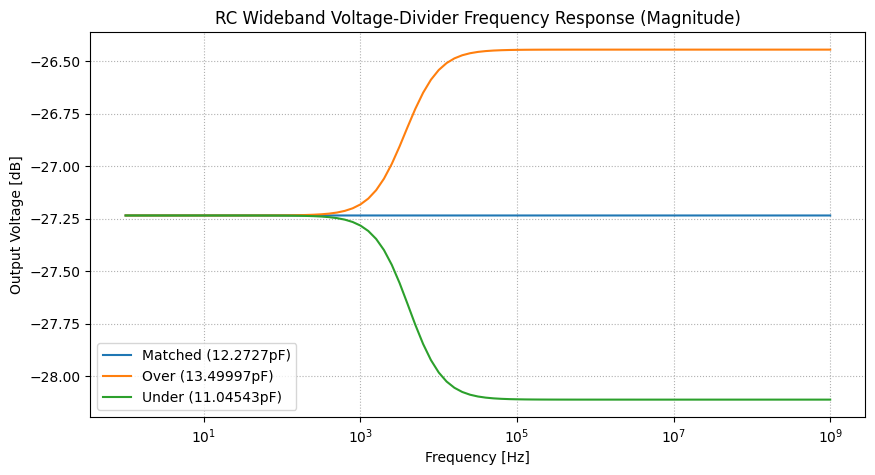

In [88]:
# @title Plot the magnitude frequency response of the wideband RC voltage-divider

# Define labels locally to reflect the Seed-based values
# C1_matched was calculated in Cell 1
v_label = [f"Matched ({C1_matched_s*1e12:.4f}pF)", "Over (13.49997pF)", "Under (11.04543pF)"]

plt.figure(figsize=(10, 5))
plt.title("RC Wideband Voltage-Divider Frequency Response (Magnitude)")

# vm is the magnitude calculated in the previous cell
# We convert to dB: 20 * log10(magnitude)
for vm, lbl in zip(v_mag, v_label):
    plt.semilogx(df_ac.freq, 20 * np.log10(vm), label=lbl, linestyle='-')

plt.xlabel("Frequency [Hz]")
plt.ylabel("Output Voltage [dB]")
plt.legend(loc='lower left')
plt.grid(True, which="both", linestyle='dotted')
plt.show()

In [92]:
import pandas as pd
import numpy as np
 
# 1. Define the frequencies you want to check
target_freqs = [1e4, 1e5, 1e6, 1e7, 1e8]  # Example: 1 kHz, 100 kHz, 10 MHz
 
print(f"{'Freq (Hz)':<12} | {'Matched (dB)':<15} | {'Over (dB)':<15} | {'Under (dB)':<15}")
print("-" * 65)
 
for f_target in target_freqs:
    # 2. Find the index closest to the target frequency
    # We assume df_ac is a DataFrame. If it's a list, convert to np.array() first.
    idx = (np.abs(df_ac['freq'] - f_target)).argmin()
   
    # Get the actual frequency found (to be sure)
    actual_f = df_ac['freq'][idx]
   
    # 3. Extract values for each case (Matched, Over, Under)
    # v_mag[0] = Matched, v_mag[1] = Over, v_mag[2] = Under
    mag_matched = v_mag[0][idx]
    mag_over    = v_mag[1][idx]
    mag_under   = v_mag[2][idx]
   
    # 4. Convert to dB
    db_matched = 20 * np.log10(mag_matched)
    db_over    = 20 * np.log10(mag_over)
    db_under   = 20 * np.log10(mag_under)
   
    print(f"{actual_f:<12.1e} | {db_matched:<15.4f} | {db_over:<15.4f} | {db_under:<15.4f}")

Freq (Hz)    | Matched (dB)    | Over (dB)       | Under (dB)     
-----------------------------------------------------------------
1.0e+04      | -27.2346        | -26.5414        | -27.9828       
1.0e+05      | -27.2346        | -26.4455        | -28.1104       
1.0e+06      | -27.2346        | -26.4444        | -28.1119       
1.0e+07      | -27.2346        | -26.4444        | -28.1119       
1.0e+08      | -27.2346        | -26.4444        | -28.1119       


PHASE 9: PLOT AC PHASE RESPONSE
Frequency Response (Phase in Degrees)

Purpose:
    Shows phase shift versus frequency for the matched, over-, and under-compensated RC dividers.
    Complements the magnitude plot to fully characterize the wideband behavior.
    Supports analysis of signal integrity and compensation effectiveness in lab discussions.

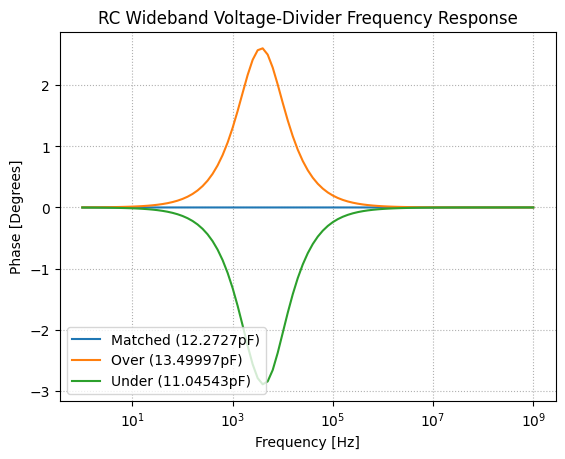

In [89]:
# @title Plot the phase frequency response of the wideband RC voltage-divider

plt.title("RC Wideband Voltage-Divider Frequency Response")

for vp,lbl in zip(v_phase,v_label):
  plt.semilogx(df_ac.freq, vp, label=lbl, linestyle='-')

plt.xlabel("Frequency [Hz]")
plt.ylabel(r"Phase [Degrees]")
plt.legend(loc='lower left')
plt.grid(linestyle='dotted')
plt.show()

IV. DATA AND OBSERVATION

Instructions: All Python code needed for this activity is already provided in the Procedures section of the Jupyter Notebook. Do not add or write new code. Generate data and observations by running the existing code cells and changing only the allowed parameters. Record all results and observations directly in the notebook.

Instruction:

    Only modify student_number.
    Do not change any other line of code in the following cells.

In [60]:
# Student Number Input
student_number = "TUPM-22-0067"  # <-- Replace with your own student number

In [61]:
# Standard Series Pools
# This defines all standard resistor and capacitor values used in the simulation.

import numpy as np

# E12 Series
E12 = np.array([1.0, 1.2, 1.5, 1.8, 2.2, 2.7, 3.3, 3.9, 4.7, 5.6, 6.8, 8.2])

# Component decades (standard range)
R_decades = np.array([1e3, 10e3, 100e3, 1e6])       # 1 kΩ to 1 MΩ
C_decades = np.array([1e-12, 10e-12, 100e-12])      # 1 pF to 100 pF

# Generate full list of standard values
R_list = np.sort(np.concatenate([E12 * d for d in R_decades]))
C_list = np.sort(np.concatenate([E12 * d for d in C_decades]))


In [62]:
# Student-Based Component Selection

# Extract digits from student_number
digits = ''.join(ch for ch in str(student_number) if ch.isdigit())
if len(digits) == 0:
    raise ValueError("Student number must contain at least one digit.")

# Stable mapping using last 6 digits
seed = int(digits[-6:])
rng = np.random.default_rng(seed)

# Select R1, R2, C2 from standard-value lists
R1_s = float(rng.choice(R_list))
R2_s = float(rng.choice(R_list))
C2_s = float(rng.choice(C_list))

# Optional: enforce R1 ≥ R2
if R1_s < R2_s:
    R1_s, R2_s = R2_s, R1_s


In [63]:
# Matched Capacitance Computation

# Wideband match condition: R1*C1 = R2*C2  -> C1 = (R2/R1)*C2
C1_matched_s = (R2_s / R1_s) * C2_s

# Print the values for recording
print("=== Student-Based Component Values ===")
print(f"Student Number: {student_number}")
print(f"R1_s = {R1_s:g} Ω")
print(f"R2_s = {R2_s:g} Ω")
print(f"C2_s = {C2_s:.3e} F  ({C2_s*1e12:.3f} pF)")
print(f"C1_matched_s = {C1_matched_s:.3e} F  ({C1_matched_s*1e12:.4f} pF)")


=== Student-Based Component Values ===
Student Number: TUPM-22-0067
R1_s = 3.3e+06 Ω
R2_s = 150000 Ω
C2_s = 2.700e-10 F  (270.000 pF)
C1_matched_s = 1.227e-11 F  (12.2727 pF)


Transient Response Data Recording

Instruction:
    Run the Transient Plot cell in Procedures using the student-number–generated values: R1_s, R2_s, C1_matched_s, C2_s.
    Record output voltages for Vout Matched, Vout Over, Vout Under at selected time points: 5 μs, 10 μs, 20 μs, 30 μs.
    Optionally, run ±10% tolerance for R1 or C1 and observe differences.

| Time (μs) | Vout Matched (V) | Vout Over (V) | Vout Under (V) |
| --------- | ---------------- | ------------- | -------------- |
| 5         | 0.0043           | 0.0051        | 0.0036         |
|10         | -0.0043          | -0.0044       | -0.0043        |
|20         | -0.0043          | -0.0045       | -0.0042        |       
|30         | -0.0043          | -0.0046       | -0.0041        |


Results Discussion:

    Compare rise time, overshoot, and settling time.

    The Matched case (Blue) provides the most efficient response, featuring a near-instantaneous rise time with essentially zero overshoot, allowing the signal to settle immediately at the steady-state voltage of approximately 0.00435 V (4.35 mV). In contrast, the Over-compensated case (Orange) has a fast rise time but exhibits significant overshoot, peaking at approximately 0.00518 V (5.18 mV). Because the circuit’s time constant 40us is much longer than the pulse width 5us, this signal struggles to settle back down to the 0.00435 V target before the pulse ends. The Under-compensated case (Green) is the least efficient in terms of speed; it starts with a low initial step of only 0.00351 V (3.51 mV) and rises slowly, failing to reach the full target voltage of 0.00435 V within the pulse duration.

    How does over- and under-compensation differ from the matched case?

    The fundamental difference lies in how the circuit processes high frequencies versus DC signals. In the Matched case, the resistive and capacitive division ratios are identical, meaning attenuation is uniform across all frequencies. Over-compensation (excess capacitance) acts as a high-frequency boost, allowing the fast edges of the square wave to pass through with less attenuation than the DC component, creating the "spikes" seen in the graph. Under-compensation (insufficient capacitance) creates a low-pass filter effect, where high-frequency edges are attenuated more than the DC component, causing the signal to appear rounded and sluggish as it slowly charges up to the final value.

    How do ±10% tolerance variations affect transient response?

    The simulation demonstrates that even a ±10% variation in capacitance can drastically compromise signal integrity in wideband applications. A +10% variation (Over-compensated) introduces amplitude distortion, where voltage spikes could be misinterpreted as noise or false logic triggers in sensitive digital circuits. A -10% variation (Under-compensated) introduces timing distortion, delaying the point at which the signal crosses a logic threshold. This confirms that for high-frequency measurements, standard component tolerances are insufficient, and a precise trimming mechanism is required to tune the probe for a perfectly resistive response.

Frequency Response Data Recording

Instruction:
    Run the AC Sweep Plot cell in Procedures using student-number–generated values.
    Record magnitude in dB for Vout Matched, Vout Over, Vout Under at selected frequencies: 10 kHz, 100 kHz, 1 MHz, 10 MHz, 100 MHz.
    Optionally, test ±10% tolerance and observe changes.

| Frequency (Hz) | Vout Matched (dB) | Vout Over (dB) | Vout Under (dB) |
| -------------- | ----------------- | -------------- | --------------- |
| 1e4            | -27.2346          | -26.5414       | -27.9828        |
| 1e5            | -27.2346          | -26.4455       | -28.1104        |
| 1e6            | -27.2346          | -26.4444       | -28.1119        |
| 1e7            | -27.2346          | -26.4444       | -28.1119        |
| 1e8            | -27.2346          | -26.4444       | -28.1119        |

Results Discussion:

    Identify flat regions, -3 dB point, and bandwidth differences.

    The Matched case 12.27pF exhibits a perfectly flat frequency response across the entire spectrum, maintaining a constant attenuation of approximately -27.2 dB from DC 1Hz well into the gigahertz range. Because the response is flat, there is no definable -3 dB point within the standard operating range, indicating that the bandwidth is effectively maximized and limited only by the parasitic properties of the components or the source. In contrast, the Under-compensated case shows a "step down" in gain starting around 4 kHz, effectively reducing the usable bandwidth for precision measurements. While it does not drop a full 3 dB (it drops roughly 0.9 dB to settle at -28.1 dB), this attenuation distorts high-frequency signal fidelity. The Over-compensated case extends the apparent bandwidth by artificially boosting high frequencies, but this comes at the cost of signal fidelity, creating a "peaking" effect rather than a true flat response.

    How does changing R or C affect attenuation and phase?
    
    The circuit behavior is divided into two domains: low frequency and high frequency. Changing Resistance (R) primarily affects the low-frequency (DC) attenuation, determined by the resistive divider ratio R_2/(R_1 + R_2). If R_1 increases, the DC output voltage decreases. Changing Capacitance (C) controls the high-frequency attenuation, determined by the capacitive divider ratio C_1/(C_1 + C_2). Regarding phase, a perfectly matched divider has a 0 degree phase shift across all frequencies. If C_1 is increased (Over-compensated), the circuit acts as a lead network, creating a positive phase shift at the transition frequency approximately 4kHz. If C_1 is decreased (Under-compensated), it acts as a lag network, creating a negative phase shift  at the transition frequency.

    Compare matched vs. over- and under-compensation at high frequencies.

    At high frequencies (above 100 kHz), the capacitors dominate the impedance of the circuit. The Matched case transitions seamlessly from its resistive attenuation to an identical capacitive attenuation level , ensuring the output represents the input accurately. The Over-compensated case  has a lower impedance in the upper branch, resulting in higher gain , which manifests as a 0.8 dB boost relative to the matched level. Conversely, the Under-compensated case has a higher impedance in the upper branch, leading to lower gain , resulting in a 0.9 dB attenuation relative to the matched level. This discrepancy explains why square waves appear distorted: the high-frequency harmonics that make up the sharp corners of the wave are either amplified (Over) or suppressed (Under).

V. DATA AND OBSERVATION
1. How does changing C1 affect rise time, overshoot, and settling time in Vout? 

    Increasing C_1 (Over-compensated) decreases the rise time (making it faster) but introduces significant overshoot, which increases the settling time as the signal must ring down to the steady state. Decreasing C_1 (Under-compensated) increases the rise time (making it slower and rounded) and creates a "creeping" settling behavior where the signal takes a long time to reach its final value. The matched C_1 provides the optimal balance: the fastest possible rise time with zero overshoot and instant settling.
    


2. Compare Vout Over and Vout Under with the matched case. How are transient and frequency responses affected?

    In the transient domain, the Over-compensated case distorts the square wave with "peaking" spikes, while the Under-compensated case distorts it with "rounding" corners compared to the perfect square wave of the Matched case. In the frequency domain, Over-compensation artificially boosts high-frequency gain (acting like a high-pass filter), whereas Under-compensation attenuates high frequencies (acting like a low-pass filter), causing the bandwidth to appear reduced compared to the flat response of the Matched case.
    


3. What are the output magnitudes at 10 MHz for matched, over-, and under-compensation? What does this tell you about high-frequency behavior?

   At 10 MHz, the output magnitudes are approximately -27.2 dB (Matched), -26.4 dB (Over), and -28.1 dB (Under). This tells us that at high frequencies, the circuit behaves purely as a capacitive divider determined by the ratio C_1/ (C_1 + C_2). The Over case has higher gain (less negative dB) because the larger C_1 presents lower impedance, while the Under case has lower gain because the smaller C_1 presents higher impedance. 


4. How does phase vary between matched, over-, and under-compensation? How could this affect signal integrity?

    The Matched case maintains a 0 degree phase shift across all frequencies, ensuring perfect signal timing. Over-compensation introduces a positive phase shift (lead), causing high-frequency components to arrive "early," while Under-compensation introduces a negative phase shift (lag), causing them to arrive "late." This affects signal integrity by creating timing errors (jitter), which can cause sensitive digital circuits to misinterpret when a logic edge actually occurs.
    

5. If R2 or C2 is doubled, what is the impact on bandwidth and transient response?

   Doubling either R_2 or C_2 increases the time constant of the bottom branch , breaking the compensation balance such that tau_1 < tau_2. This results in an under-compensated transient response, characterized by rounded corners and a slow rise time. Additionally, doubling either component lowers the pole frequency of the system, effectively reducing the overall bandwidth by half, making the divider slower and less responsive to fast signals. 




VI. CONCLUSION

        This activity successfully demonstrated the critical role of frequency compensation in wideband RC voltage dividers. Through simulation, it was observed that signal integrity is only maintained when the resistive divider ratio matches the capacitive divider ratio R1C1 = R2C2, resulting in a flat frequency response and a perfect square wave output. Deviations from this matched state, such as over-compensation, lead to high-frequency peaking and transient overshoot, while under-compensation results in high-frequency attenuation and rounded signal edges. These findings illustrate why precision-tunable capacitors are essential in instruments like oscilloscope probes to ensure accurate signal representation across a broad frequency spectrum.




